<a href="https://colab.research.google.com/github/MJSahebnasi/temporal-network-platform/blob/main/thesis_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx

from typing import List, Type
import abc

import copy

import heapq


# Events Model

In [2]:
class Event:
  def __init__(self, t) -> None:
    self.time = t
    
  def __repr__(self):
    return "<time:" + str(self.time) + ">"

  # will be used in heap, when selecting the earliest event
  def __lt__(self, other):
    return self.time < other.time

  @abc.abstractmethod
  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    return

class NodeEvent(Event):
  def __init__(self, t, node) -> None:
    super().__init__(t)
    self.node = node

  def __repr__(self):
    return super().__repr__()[:-1] + "-node:"+str(self.node) + ">"

class NodeEntranceEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-entrance" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    ### intentionally won't handle this scenario:
    # if self.node in dead_and_attacked_nodes:
    #   return
    ###
    sim_G.add_node(self.node)
    edges = [(self.node, i) for i in _current_neighbors(sim_G, orig_G, self.node)]
    sim_G.add_edges_from(edges)

class NodeDeathEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-death" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # might already be off or attacked
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)
    # no matter the if, this must execute:
    dead_and_attacked_nodes.add(self.node)

class NodeAttackEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-attack" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # might already be off or dead
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)
    # no matter the if, this must execute:
    dead_and_attacked_nodes.add(self.node)

class NodeOnEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-on" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # the node might die or get attacked while off
    if self.node in dead_and_attacked_nodes:
      return
    sim_G.add_node(self.node)
    edges = [(self.node, i) for i in _current_neighbors(sim_G, orig_G, self.node)]
    sim_G.add_edges_from(edges)

class NodeOffEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-off" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # the node might be already dead or attacked
    # instead of using "dead_and_attacked_nodes", I used "nodes()"
    #   this way consecutive offs will be handled
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)

def _current_neighbors(sim_G, orig_G, node):
  return set.intersection(set(sim_G.nodes()), set(orig_G.neighbors(node)))

# Simulation

In [3]:
from numpy.ma.core import nonzero
class Simulation:   

  ########################## init ##########################

  def create(self, G):
    self.orig_G = G
    self.sim_G = copy.deepcopy(G)
    self.dead_and_attacked_nodes = set() # not off nodes

    self.has_entrance_process = False
    self.has_onoff_process = False
    self.has_node_lifespan = False
    self.has_attack_process = False

    self.events = []
    
    self.snapshots = []
    self.snapshot_times = []

    return self

  def with_entrance_process(self, node_entrance_times):
    ### TODO: parameter validation ###
    self.has_entrance_process = True
    self.node_entrance_times = node_entrance_times
    return self

  def with_node_onoff_process(self, node_on_times, node_off_times):
    ### TODO: parameter validation ###
    self.has_onoff_process = True
    self.node_on_times = node_on_times
    self.node_off_times = node_off_times
    return self

  def with_node_lifespans(self, node_death_times):
    ### TODO: parameter validation ###
    self.has_node_lifespan = True
    self.node_death_times = node_death_times
    return self

  def with_attack_process(self, node_attack_times):
    """
    If you don't want a node to be attacked, just set a NEGATIVE attack time for it.
    example:
    [10, -1, -1, 13]
    The 2nd and the 3rd node will not be attacked.
    """
    ### TODO: parameter validation ###
    self.has_attack_process = True
    self.node_attack_times = node_attack_times
    return self


  ########################## input validation ##########################


  def __entrance_input_validation(self):
    if len(self.node_entrance_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_entrance_times) & the number of nodes not the same !!!')

  def __onoff_input_validation(self):
    n = self.orig_G.number_of_nodes()
    if len(self.node_on_times) != n:
      raise ValueError('!!! len(node_on_times) & the number of nodes not the same !!!')
    if len(self.node_off_times) != n:
      raise ValueError('!!! len(node_off_times) & the number of nodes not the same !!!')

  def __death_input_validation(self):
    if len(self.node_death_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_death_times) & the number of nodes not the same !!!')


  def __attack_input_validation(self):
    if len(self.node_attack_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_attack_times) & the number of nodes not the same !!!')


  ########################## prepair events ##########################


  def create_entrance_events(self):

    self.__entrance_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())
    self.sim_G = nx.Graph()

    for i in range(n):
      node = nodes[i]
      e = NodeEntranceEvent(self.node_entrance_times[i], node)
      self.events.append(e)

  def create_onoff_events(self):

    self.__onoff_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      for t in self.node_on_times[i]:
        e = NodeOnEvent(t, node)
        self.events.append(e)
      for t in self.node_off_times[i]:
        e = NodeOffEvent(t, node)
        self.events.append(e)

  def create_death_events(self):

    self.__death_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      e = NodeDeathEvent(self.node_death_times[i], node)
      self.events.append(e)

  def create_attack_events(self):

    self.__attack_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      t = self.node_attack_times[i]

      if t < 0:
        continue

      e = NodeAttackEvent(t, node)
      self.events.append(e)

  def prepair_events(self):
    if self.has_entrance_process:
      self.create_entrance_events()

    if self.has_onoff_process:
      self.create_onoff_events()

    if self.has_node_lifespan:
      self.create_death_events()

    if self.has_attack_process:
      self.create_attack_events()

    heapq.heapify(self.events)


  ########################## run ##########################


  def take_snapshots(self, time):
    # print('t:', time)
    while self.snapshot_times and self.snapshot_times[-1] < time: # cannot be <=
      t = self.snapshot_times.pop()
      g = copy.deepcopy(self.sim_G)
      self.snapshots.append(g)

  def run(self, snapshot_times=[]):
    """
    snapshot_times: optional arg
      if provided, must be a sorted (ascending) list of times (could be float or int)
      times greater than the simulation duration will be ignored
    """

    if snapshot_times:
      self.snapshot_times = copy.deepcopy(snapshot_times)
      self.snapshot_times.reverse() # so that we can just pop the smallest time, no shift

    self.prepair_events()

    sim_time = 0
    
    while len(self.events) > 0:

      e = heapq.heappop(self.events)

      # print('e t:', e.time)
      # print('s t:', sim_time)
      if e.time > sim_time:
        if self.snapshot_times:
          self.take_snapshots(e.time)
        # print('snapshots:', self.snapshots)
        # print('snapshot times:', self.snapshot_times)

      e.execute(self.sim_G, self.orig_G, self.dead_and_attacked_nodes)

      sim_time = e.time

      # print(e)
      # print(self.sim_G)
      # print('dead nodes', self.dead_and_attacked_nodes)
      # print('nodes', self.sim_G.nodes())
      # print('edges', self.sim_G.edges())
      # print('----------------')

    # taking the remaining snapshots, after the last event (equal to the final self.sim_G)
    for t in self.snapshot_times:
      self.snapshots.append(copy.deepcopy(self.sim_G))
    
    return self.sim_G, self.snapshots

In [4]:
# has good things in it
# like death after attack
G = nx.erdos_renyi_graph(n=3,p=0.7)
ent = [0, 1, 2]
dth = [10, 50, 55]
atk = [8.5, -1, -1]
off = [[3], [10, 20], []]
on  = [[5], [12.5], []]

snp_t = [0, 1, 2, 4, 5, 6.5, 54, 55, 56]

s = Simulation().create(G).with_entrance_process(ent).with_node_lifespans(dth).with_attack_process(atk).with_node_onoff_process(on, off)
res, snaps = s.run(snapshot_times = snp_t)

In [5]:
# print('in:')
# print(G)
# print(G.nodes())
# print(G.edges())
# print('*********')
# print('res:')
# print(res)
# print(res.nodes())
# print(res.edges())
# print('*********')
# print(len(snaps))
# print(len(snp_t))
# print('*********')
# for i in range(len(snaps)):
#   g = snaps[i]
#   t = snp_t[i]
#   print(i)
#   print('t:', t)
#   print(g)
#   print(g.nodes())
#   print(g.edges())
#   print('-------')

# Diagram Package

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_distribution(G):
  degree_distrib = nx.degree_histogram(G)
  x = range(len(degree_distrib))

  plt.figure()

  plt.plot(x, degree_distrib, marker='o')
  title = 'degree distribution'
  plt.title(title)
  plt.grid()
  plt.xticks(x)
  plt.yticks(np.arange(np.min(degree_distrib), np.max(degree_distrib) + 1, 1))
  plt.xlabel('degree')
  plt.ylabel('nodes count')
  plt.tick_params(labelrotation=45)

  plt.show()


def plot_onoff_graph(sim_G, orig_G):
  nx.draw_circular(orig_G)
  nx.draw_circular(sim_G)
  

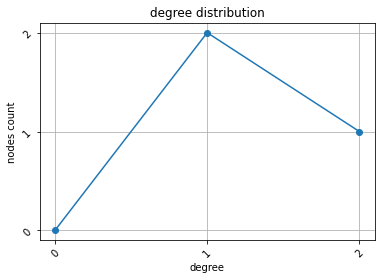

In [7]:
plot_degree_distribution(G)

# Data Generator Package

In [8]:
def poisson_process(landa, max_time):
  """
  returns a list of numbers (times, float) based on Poisson Process
  landa: exponential distribution's parameter
  max_time: the times in the returned list will not exceed max_time
  """
  pass

In [17]:
import math

def onoff_data_generator(on_durations, off_durations, start_time=0, max_time=math.inf):
  """
  input:
    example:
    1. on_durations = [ [3, 4], [10] ]
      -> node0 has 2 <on periods>, which last 3 and 4 time units
      -> node1 has 1 <on period>, which lasts 10 time units
    2. off_durations is the same
    ### both on_durations and off_durations must have the same length
    3. start_time: on/off durations will be added to this (events will happen after this time)
    4. max_time: on/off event times will not exceed max_time (remaining on/off durations will be ignored)
  how it works:
    I assume all nodes are <on> first.
    For each node, takes the first <on> duration, so the end of it will be the first <off> event's time;
    then adds the first <off duration> to the time, which gives us the first <on> event's time. And keeps
    doing this until we run out of either <on duration>s or <off duration>s.
  retuens:
    on_times: times a node becomes online, for each node
    off_times: times a node becomes offline, for each node
     -> the same format that with_onoff_process() requires
    example:
    on_times= [[1,3,4], []]
    off_times = [[2,3.5], [1]]
      -> node0 events: 1:on, 2:off, 3:on, 3.5:off, 4:on
      -> node1 events: 1:off
  """

  if len(on_durations) != len(off_durations):
    raise ValueError('!!! len(on_durations) and len(off_durations) must be the same !!!')
  
  n = len(on_durations)

  on_times = [[] for i in range(n)]
  off_times = [[] for i in range(n)]

  for node_id in range(n):
    i_on = 0
    i_off = 0
    t = start_time
    while True:
      if i_on < len(on_durations[node_id]):
        off_event_time = t + on_durations[node_id][i_on]
        if off_event_time < max_time:
          off_times[node_id].append(off_event_time)
          t = off_event_time
          i_on += 1
        else:
          off_times[node_id].append(max_time)
          break
      else:
        break
      if i_off < len(off_durations[node_id]):
        on_event_time = t + off_durations[node_id][i_off]
        if off_event_time < max_time:
          on_times[node_id].append(on_event_time)
          t = on_event_time
          i_off += 1
        else:
          on_times[node_id].append(max_time)
          break
      else:
        break
  
  return on_times, off_times

In [19]:
# test
on_d = [[1, 1, 0.5, 2], [2, 0], [1]]
of_d = [[1, 3],         [1, 1, 2], []]

# node0: 1:off, 2:on, 3:off, 6:on, 6.5:off
# node1: 2:off, 3:on, 3:off, 4:on
# node2: 1:off

on_t, of_t = onoff_data_generator(on_d, of_d)
print('on:', on_t)
print('off:', of_t)

on: [[2, 6], [3, 4], []]
off: [[1, 3, 6.5], [2, 3], [1]]


# Scenario: SW, SF

## functions

In [9]:
def OnOFF_Scenario_A(G, snp_t):

  

  s = Simulation().create(G).with_node_onoff_process(on, off)
  res, snaps = s.run(snapshot_times = snp_t)
  plot_onoff_graph(sim_G, G)

## results

In [10]:
n = 100
k = 10 
p = 0.3

G_SW_A = nx.watts_strogatz_graph(n, k, p)

landa = 0.005
mue_1 = 0.005
mue_2 = 0.01



OnOFF_Scenario_A(G_SW_A)


TypeError: ignored